<h1>1 + 1 = 1 or Record Deduplication with Python</h1>
<h3 style="margin-top: 0.5em; color: #666">PyCon US 2020</h3>

Flávio Juvenal  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
<p>
    Partner at <a href="http://www.vinta.com.br?dedupe-slides=1"><img class="vinta_logo" style="display: inline-block; margin-left: 0;" src="vinta.png" width="300px"></a>
</p>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Those lines set the GOOGLE_API_KEY to enable the geocoder.
# To make the geocoder work, grab an API key at: https://cloud.google.com/maps-platform/#get-started
# Then create a .env file and add this line: GOOGLE_API_KEY=key-value-here
# Finally, run the lines below.

from dotenv import load_dotenv
load_dotenv(verbose=True)

True

<p style="font-size: 1.5em; text-weight: bold">
    Jupyter Notebook source at: <a href="https://github.com/vintasoftware/deduplication-slides/tree/pycon-2020">github.com/vintasoftware/deduplication-slides/tree/pycon-2020</a>
</p>

## Real world data is a mess!
Probably you dealt with data like this before:

In [3]:
import pandas as pd

data = [
    ("ça Va", "R. Cap. Rebelinho, 519, Recife"),
    ("Ca Va", "R. Capitão Rebelinho, 519, Recife/PE"),
    ("Côté Soleil","50-12 Skillman Ave, queens, NY"),
    ("cote soleil","50 Skillman Ave, nyc"),
    ("Cafe Harvest", "karmeliterplatz 1, Vienna"),
    ("Harvest Café", "Karmeliterpl. 1, 1020, Wien"),
]

df = pd.DataFrame(data, columns=['name', 'address'])

In [4]:
df

,name,address
0,ça Va,"R. Cap. Rebelinho, 519, Recife"
1,Ca Va,"R. Capitão Rebelinho, 519, Recife/PE"
2,Côté Soleil,"50-12 Skillman Ave, queens, NY"
3,cote soleil,"50 Skillman Ave, nyc"
4,Cafe Harvest,"karmeliterplatz 1, Vienna"
5,Harvest Café,"Karmeliterpl. 1, 1020, Wien"


The solution is to perform **Deduplication**  
(aka [Record Linkage](https://en.wikipedia.org/wiki/Record_linkage) and Entity Resolution).

Deduplication works by joining records in a **fuzzy way** using data like names, addresses, phone numbers, dates, etc.

## Fuzzy Similarity and Data Cleaning

You can get fuzzy similarity of **a pair of strings** by using edit distance:

In [5]:
from py_stringmatching import Levenshtein
Levenshtein().get_sim_score("Cafe Harvest", "Harvest Café")

0.16666666666666663

But `0.16` is too little similarity for very similar names...  
The problem here is that tokens (words) have a different order.

Is there an alternative similarity measure we could use that **ignores token order**?

In [6]:
from py_stringmatching import MongeElkan
MongeElkan(
    sim_func=Levenshtein().get_sim_score
).get_raw_score("Cafe Harvest".split(), "Harvest Café".split())

0.875

It worked! But there's room for improvement.  
How to get rid of the acute **accent** on `"Café"`?

In [7]:
import unidecode

unidecode.unidecode("Café")

'Cafe'

In [8]:
MongeElkan(
    sim_func=Levenshtein().get_sim_score
).get_raw_score(
    unidecode.unidecode("Cafe Harvest").split(),
    unidecode.unidecode("Harvest Café").split()
)

1.0

Great, so maybe we can consider restaurant pairs with **high name similarity** as **matches**.

But it's useful to use other **fields** as well.

For **addresses**, you can get fuzzy similarity by first geocoding them:

In [9]:
import geocoder

x = geocoder.google("50-12 Skillman Ave, queens, NY").latlng
y = geocoder.google("50 Skillman Ave, nyc").latlng
print(x)
print(y)

[40.7459396, -73.913945]
[40.7458604, -73.9135648]


And then computing the **distance** between them:

In [10]:
import haversine

haversine.haversine(x, y, unit=haversine.Unit.KILOMETERS)

0.03321774428617794

**Close enough** addresses can be considered as **matches**.

Let's compare all the restaurant pairs now.

## Comparing all to all

This is our dataset with **latlng**:

In [11]:
def address_to_latlng(address):
    return geocoder.google(address).latlng

df = df.assign(latlng=df['address'].apply(address_to_latlng))
df

,name,address,latlng
0,ça Va,"R. Cap. Rebelinho, 519, Recife","[-8.095537, -34.884008]"
1,Ca Va,"R. Capitão Rebelinho, 519, Recife/PE","[-8.095537, -34.884008]"
2,Côté Soleil,"50-12 Skillman Ave, queens, NY","[40.7459396, -73.913945]"
3,cote soleil,"50 Skillman Ave, nyc","[40.7458604, -73.9135648]"
4,Cafe Harvest,"karmeliterplatz 1, Vienna","[48.2155105, 16.3798774]"
5,Harvest Café,"Karmeliterpl. 1, 1020, Wien","[48.2155105, 16.3798774]"


In [12]:
df = df[['name', 'latlng']]

Lets grab the **IDs** of our records:

In [13]:
list(df.index)

[0, 1, 2, 3, 4, 5]

And compute **all possible pairs** to match:

In [14]:
import itertools

all_pairs = list(itertools.combinations(df.index, 2))
print("all_pairs:", all_pairs)
print("len(all_pairs):", len(all_pairs))

all_pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
len(all_pairs): 15


Checking some of the **pairs**:

In [15]:
for i, pair in enumerate(all_pairs):
    display(df.loc[list(pair)])
    if i == 2:
        break

,name,latlng
0,ça Va,"[-8.095537, -34.884008]"
1,Ca Va,"[-8.095537, -34.884008]"


,name,latlng
0,ça Va,"[-8.095537, -34.884008]"
2,Côté Soleil,"[40.7459396, -73.913945]"


,name,latlng
0,ça Va,"[-8.095537, -34.884008]"
3,cote soleil,"[40.7458604, -73.9135648]"


Now we'll represent pairs **`dict`** records pairs:

In [16]:
record_pair = df.loc[list(all_pairs[10])].to_dict(orient='records')
display(record_pair)

[{'name': 'Côté Soleil', 'latlng': [40.7459396, -73.913945]},
 {'name': 'Cafe Harvest', 'latlng': [48.2155105, 16.3798774]}]

We do that becuase we'll create **scoring functions** to compare the fields from each record pair:

In [17]:
def _compare_name(x, y):
    return MongeElkan(
        sim_func=Levenshtein().get_sim_score
    ).get_raw_score(x.split(), y.split())

def _compare_latlng(x, y):
    return haversine.haversine(x, y, unit=haversine.Unit.KILOMETERS)

def compare_pair(record_x, record_y):
    return {
        'name': _compare_name(record_x['name'], record_y['name']),
        'latlng': _compare_latlng(record_x['latlng'], record_y['latlng'])
    }

In [18]:
compare_pair(*record_pair)

{'name': 0.20833333333333331, 'latlng': 6788.026538789064}

This example pair has **low similarity of names** and **distant addresses**, so it's clearly a **non-match**.

Now let's score **all pairs**:

In [19]:
pair_scores = []

for pair in all_pairs:
    record_x, record_y = df.loc[list(pair)].to_dict(orient='record')
    score_dict = compare_pair(record_x, record_y)
    pair_scores.append(score_dict)

score_df = pd.DataFrame.from_records(
    pair_scores,
    index=pd.MultiIndex.from_tuples(all_pairs)
)
score_df

name       latlng
0 1  0.750000     0.000000
  2  0.000000  6739.592291
  3  0.000000  6739.563220
  4  0.250000  8014.299618
  5  0.250000  8014.299618
1 2  0.125000  6739.592291
  3  0.000000  6739.563220
  4  0.375000  8014.299618
  5  0.375000  8014.299618
2 3  0.541667     0.033218
  4  0.208333  6788.026539
  5  0.321429  6788.026539
3 4  0.208333  6788.007857
  5  0.142857  6788.007857
4 5  0.875000     0.000000

Let's **filter** the scores dataframe to look for matches:

In [20]:
match_df = score_df.loc[(score_df['name'] >= 0.5) & (score_df['latlng'] < 1)]
match_df

,,name,latlng
0,1,0.750000,0.000000
2,3,0.541667,0.033218
4,5,0.875000,0.000000


In [21]:
for pair in match_df.index:
    display(df.loc[list(pair)])

,name,latlng
0,ça Va,"[-8.095537, -34.884008]"
1,Ca Va,"[-8.095537, -34.884008]"


,name,latlng
2,Côté Soleil,"[40.7459396, -73.913945]"
3,cote soleil,"[40.7458604, -73.9135648]"


,name,latlng
4,Cafe Harvest,"[48.2155105, 16.3798774]"
5,Harvest Café,"[48.2155105, 16.3798774]"


For 6 records is fine to compare all against all: we get 15 pairs.  
But for **1 million records** we would get almost **500 BILLION pairs**.

The number of pairs grows too fast as the number of records grows:  
it **grows quadratically** with the formula `len(score_df) == len(df) * (len(df) - 1) / 2`

To avoid wasting too much time comparing a lot of pairs, we need **blocking**.  
We need to produce only pairs that are **good candidates** of being duplicates.

## Fingerprinting and Blocking

What would be a good way of blocking **restaurant names**?

In [22]:
list(df.name.values)

['ça Va',
 'Ca Va',
 'Côté Soleil',
 'cote soleil',
 'Cafe Harvest',
 'Harvest Café']

We need a **fingerprint** function that cleans up irrelevant name variations:

In [23]:
import re

def name_fingerprint(name):
    # remove accents
    name = unidecode.unidecode(name)
    # lowercase
    name = name.lower()
    # sort tokens
    name = ' '.join(sorted(name.split()))
    # remove non-alphanumeric
    name = re.sub('[^0-9a-zA-Z ]+', '', name)
    return name

name_fingerprint("Harvest Café")

'cafe harvest'

In [24]:
df = df.assign(name_fingerprint=df.name.apply(name_fingerprint))
df

,name,latlng,name_fingerprint
0,ça Va,"[-8.095537, -34.884008]",ca va
1,Ca Va,"[-8.095537, -34.884008]",ca va
2,Côté Soleil,"[40.7459396, -73.913945]",cote soleil
3,cote soleil,"[40.7458604, -73.9135648]",cote soleil
4,Cafe Harvest,"[48.2155105, 16.3798774]",cafe harvest
5,Harvest Café,"[48.2155105, 16.3798774]",cafe harvest


In [25]:
df.groupby('name_fingerprint').indices

{'ca va': array([0, 1]),
 'cafe harvest': array([4, 5]),
 'cote soleil': array([2, 3])}

It worked! We've **blocked together** different restaurant names with our fingerprint function.

### Examples of fingerprint functions for blocking

#### Strings
- Ordered tokens
- Common token
- First N tokens
- N-chars prefix/suffix
- Acronym
- [Phonetic encoding](https://abydos.readthedocs.io/en/latest/abydos.phonetic.html)

#### Lat-lngs
- [Grid](https://github.com/dedupeio/dedupe/blob/7df2ab5ef268080a60e1f3f31248de985d93c598/dedupe/predicates.py#L510-L523)
- [Geohash](https://github.com/vinsci/geohash/) prefixes

#### Numbers
- [Order of magnitude](https://github.com/dedupeio/dedupe/blob/7df2ab5ef268080a60e1f3f31248de985d93c598/dedupe/predicates.py#L526-L530)

#### Sets
- Any common element
- Max element
- Min element

#### Anything
- Exact value

But what type fingerprinting would block together **approximate** matches  
like `"Harvest Cafe"` and `"Havest Coffee"`?

## Approximate Blocking

Approximate Blocking is a **challenging** area of research in Entity Resolution.  

A good approximate blocking function is able to block together similar pairs, **without** resorting to all-to-all comparisons.

In [26]:
approximate_names = [
    "harvest cafe",
    "havest coffee",
    "havest cofee",
    "cote soleil",
    "cote soliel",
    "cotee solliel",
    "ca va",
    "ca vaa",
]

In [27]:
from helpers.tfidf_blocker import block_with_tfidf_ann

display(block_with_tfidf_ann(approximate_names, threshold=0.5, k=3))

array([2, 2, 2, 0, 0, 0, 1, 1])

We won't detail how this works here, but you can check these resources:  
- Stay tuned on [Vinta's blog](https://www.vinta.com.br/blog). I'll be posting experiments on approximate blocking with Approximate Nearest Neighbors.
- [Video: Data Deduplication using Locality Sensitive Hashing](https://www.youtube.com/watch?v=n3dCcwWV4_k&list=PLk3qn9pE_2w9WIuE2tWxHR4nwO_qVgT5C&index=4). Check also this [informative tutorial](https://mattilyra.github.io/2017/05/23/document-deduplication-with-lsh.html) from the same author.
- [Article: A Review of Unsupervised and Semi-supervised Blocking Methods for Record Linkage](https://www.researchgate.net/publication/329602222_A_Review_of_Unsupervised_and_Semi-supervised_Blocking_Methods_for_Record_Linkage).
- [Article: A Survey of Blocking and Filtering Techniques for Entity Resolution](https://www.researchgate.net/publication/333130293_A_Survey_of_Blocking_and_Filtering_Techniques_for_Entity_Resolution). Related [slides](http://www.paris-bigdata.org/2017/slides/palpanas.pdf).
- [Article: Scalable Entity Resolution Using Probabilistic Signatures on Parallel Databases](https://arxiv.org/abs/1712.09691). Check also this [Python implementation](https://blocklib.readthedocs.io/en/latest/blocking-schema.html) and this [talk video](https://www.youtube.com/watch?v=F-Kf52yvTCU&list=PLk3qn9pE_2w9WIuE2tWxHR4nwO_qVgT5C&index=15).
- [Article: Blocking Strategies to Accelerate Record Matching for Big Data Integration](http://ceur-ws.org/Vol-2507/219-224-paper-38.pdf).

Now that we can block well, can we do better on the **classification** of matches vs non-matches?

## Classification

Remember we've just used a **simple rule** to classify our pairs as matches:

In [28]:
match_df = score_df.loc[(score_df['name'] >= 0.5) & (score_df['latlng'] < 1)]
match_df

,,name,latlng
0,1,0.750000,0.000000
2,3,0.541667,0.033218
4,5,0.875000,0.000000


That can work well on simple and small datasets, but for complex and larger ones, a **Machine Learning Classifier** will probably work better:

```python
matching_pairs = classifier.predict(score_df)
```

The problem is: how to train that classifier?

It can be challanging to **manually find matching pairs** in a gigantic dataset, becuase the number of matching pairs tends to be much smaller than the non-matching pairs.

## Active Learning

To explain Active Learning, we'll work with a custom dataset based on the [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html) dataset:
- a well-known dataset used by researchers
- made of 881 restaurant records from the Fodor's and Zagat's restaurant guides
- contains 150 duplicates

\* We've introduced some changes that you can check by doing a `diff restaurant.original.csv restaurant.csv`

In [29]:
df_with_truth = pd.read_csv('restaurant.csv', skip_blank_lines=True)
df_with_truth.head(9)

,name,addr,city,phone,type,cluster
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2


The dataset comes with the **true matches** indicated by the `cluster` column. We use that to compute the `golden_pairs_set`:

In [30]:
golden_pairs_set = {
    tuple(sorted(pair))
    for cluster_ids in df_with_truth.groupby('cluster').indices.values()
    for pair in itertools.combinations(cluster_ids, 2)
}
len(golden_pairs_set)

150

We'll remove the `phone` and `type` fields to makes things more **difficult**:

In [31]:
df = df_with_truth.drop(columns=['cluster', 'phone', 'type'])
df.head(9)

,name,addr,city
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles
2,arnie morton,435 s. la cienega boulevard,los angeles
3,art's delicatessen,12224 ventura blvd.,studio city
4,art's deli,12224 ventura blvd.,studio city
5,art's deli,12224 ventura blvd.,los angeles
6,hotel bel-air,701 stone canyon rd.,bel air
7,bel-air hotel,701 stone canyon rd.,bel air
8,bel-air,701 stone canyon road,bel air


**Geocoding** `addr`:

In [32]:
import numpy as np

all_addresses = df['addr'].str.cat(df['city'], sep=', ').values
unique_addresses = np.unique(all_addresses)
print(len(all_addresses), len(unique_addresses))

881 819


In [33]:
import requests
import os.path
import json

geocoding_filename = 'address_to_geocoding.json'

def geocode_addresses(address_to_geocoding):
    remaining_addresses = (
        set(unique_addresses) -
        set(k for k, v in address_to_geocoding.items() if v is not None and 'lat' in v))

    with requests.Session() as session:
        for i, address in enumerate(remaining_addresses):
            print(f"Geocoding {i + 1}/{len(remaining_addresses)}")
            geocode_result = geocoder.google(address, session=session)
            address_to_geocoding[address] = geocode_result.json

        with open(geocoding_filename, 'w') as f:
            json.dump(address_to_geocoding, f, indent=4)

if not os.path.exists(geocoding_filename):
    address_to_geocoding = {}
    geocode_addresses(address_to_geocoding)
else:
    with open(geocoding_filename) as f:
        address_to_geocoding = json.load(f)
    geocode_addresses(address_to_geocoding)
 
address_to_postal = {
    k: v['postal']
    for k, v in address_to_geocoding.items()
    if v is not None and 'postal' in v
}
address_to_latlng = {
    k: (v['lat'], v['lng'])
    for k, v in address_to_geocoding.items()
    if v is not None
}
print(f"Failed to get postal from {len(address_to_geocoding) - len(address_to_postal)}")
print(f"Failed to get latlng from {len(address_to_geocoding) - len(address_to_latlng)}")

Failed to get postal from 10
Failed to get latlng from 0


In [34]:
def assign_postal_latlng(df):
    addresses = df['addr'].str.cat(df['city'], sep=', ')
    addresses_to_postal = [address_to_postal.get(a) for a in addresses]
    addresses_to_latlng = [address_to_latlng[a] if a in address_to_latlng else None for a in addresses]

    return df.assign(postal=addresses_to_postal, latlng=addresses_to_latlng)

In [35]:
df = assign_postal_latlng(df)
df.head(6)

,name,addr,city,postal,latlng
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,90048,"(34.0707083, -118.3765626)"
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,90048,"(34.0707083, -118.3765626)"
2,arnie morton,435 s. la cienega boulevard,los angeles,90048,"(34.0707083, -118.3765626)"
3,art's delicatessen,12224 ventura blvd.,studio city,91604,"(34.1429632, -118.3994648)"
4,art's deli,12224 ventura blvd.,studio city,91604,"(34.1429632, -118.3994648)"
5,art's deli,12224 ventura blvd.,los angeles,91604,"(34.1429632, -118.3994648)"


Note we used the geocoder to get **`postal` code** as well. It's especially useful for blocking.

A Python library called [**Dedupe**](https://docs.dedupe.io/en/latest/index.html) implements Active Learning and has a friendly interface. Let's see it in practice:

In [36]:
from rf_dedupe import RFDedupe
import dedupe

fields = [
    {
        'field': 'name',
        'variable name': 'name',
        'type': 'String',
    },
    {
        'field': 'addr',
        'variable name': 'addr',
        'type': 'String',
    },
    {
        'field': 'postal',
        'variable name': 'postal',
        'type': 'String'
    },
    {
        'field': 'latlng',
        'variable name': 'latlng',
        'type': 'LatLong'
    },
]
deduper = RFDedupe(fields, num_cores=1)

Our `RFDedupe` is a bit different than the original `Dedupe`, because we changed it to use a [**Random Forest classifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from scikit-learn. By default Dedupe uses a simpler logistic regression model.

Use our code as base and try different classifiers!

In [37]:
import os

settings_filename = 'dedupe-2-settings.pickle'
if os.path.exists(settings_filename):
    with open(settings_filename, 'rb') as sf:
        deduper = dedupe.StaticDedupe(sf, num_cores=1)

INFO:dedupe.api:((SimplePredicate: (firstTokenPredicate, name), SimplePredicate: (sameSevenCharStartPredicate, name)), (SimplePredicate: (alphaNumericPredicate, postal), SimplePredicate: (firstIntegerPredicate, addr)))


We need to **adapt** the data a bit to the format Dedupe wants:

In [38]:
data_for_dedupe = (
    df
    .replace({np.nan: None})
    # assigning cluster for generating training,
    # not used by Dedupe
    .assign(cluster=df_with_truth['cluster'])
    .to_dict('index')
)

We train Dedupe by **labeling** the examples of matches and nonmatches it asks us:

In [39]:
# deduper.prepare_training(data_for_dedupe)  
# dedupe.console_label(deduper)
# deduper.train(index_predicates=False)

with open('training-dedupe-2-input-output.txt') as t:
    print('\n'.join(t.read().split('\n')[:262]))
    print('...')

name : palace court
addr : 3570 las vegas blvd. s
postal : 89109
latlng : (36.1161559, -115.1750576)

name : palace court
addr : 3570 las vegas blvd. s.
postal : 89109
latlng : (36.1161559, -115.1750576)

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
y

name : valentino
addr : 3115 pico blvd.
postal : 90404
latlng : (34.026337, -118.4570875)

name : valentino
addr : 3115 pico blvd.
postal : 90404
latlng : (34.026337, -118.4570875)

1/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
y

name : nikolai's roof
addr : 255 courtland st.  at harris st.
postal : 30303
latlng : (33.761546, -84.383562)

name : nikolai's roof
addr : 255 courtland st.
postal : 30303
latlng : (33.761546, -84.383562)

2/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
y

name : fenix
addr : 8358 sunset blvd.
postal : 90069
latlng : (34.0951411

You can check the full training at `training-dedupe-2-input-output.txt`.

If you want to train it yourself, do a `rm dedupe-2-settings.pickle dedupe-2-training.json` and run this whole Active Learning session again.

In [40]:
from dedupe.convenience import unique


def _get_n_match_n_distinct(training_pairs, examples_buffer):
    n_match = (len(deduper.training_pairs['match']) +
               sum(label == 'match' for _, label in examples_buffer))
    n_distinct = (len(deduper.training_pairs['distinct']) +
                  sum(label == 'distinct' for _, label in examples_buffer))
    return n_match, n_distinct


def auto_label(deduper):
    # based on: dedupe.convenience.console_label
    fields = unique(field.field
                    for field
                    in deduper.data_model.primary_fields)
    buffer_len = 1
    examples_buffer = []
    uncertain_pairs = []
    n_match, n_distinct = _get_n_match_n_distinct(deduper.training_pairs, examples_buffer)
    
    while n_match < 15 or n_distinct < 20:
        if not uncertain_pairs:
            uncertain_pairs = deduper.uncertain_pairs()
        record_pair = uncertain_pairs.pop()
        
        n_match, n_distinct = _get_n_match_n_distinct(deduper.training_pairs, examples_buffer)
        
        for pair in record_pair:
            for field in fields:
                line = "%s : %s" % (field, pair[field])
                print(line)
            print()
        print(f"{n_match}/10 positive, {n_distinct}/10 negative")
        print("Do these records refer to the same thing?")
        print("(y)es / (n)o / (u)nsure / (f)inished")
        
        if record_pair[0]['cluster'] == record_pair[1]['cluster']:
            print('y')
            examples_buffer.insert(0, (record_pair, 'match'))
        else:
            print('n')
            examples_buffer.insert(0, (record_pair, 'distinct'))
        print()

        if len(examples_buffer) > buffer_len:
            record_pair, label = examples_buffer.pop()
            if label in ['distinct', 'match']:
                examples = {'distinct': [], 'match': []}
                examples[label].append(record_pair)
                deduper.mark_pairs(examples)
    
    for record_pair, label in examples_buffer:
        if label in ['distinct', 'match']:
            examples = {'distinct': [], 'match': []}
            examples[label].append(record_pair)
            deduper.mark_pairs(examples)

In [41]:
import os

if not isinstance(deduper, dedupe.StaticDedupe):
    training_filename = 'dedupe-2-training.json'
    if os.path.exists(training_filename):
        with open(training_filename) as tf:
            deduper.prepare_training(data_for_dedupe, tf)
    else:
        deduper.prepare_training(data_for_dedupe)

    # dedupe.console_label(deduper)
    auto_label(deduper)
    
    with open(training_filename, 'w') as tf:
        deduper.write_training(tf)
    
    deduper.train(index_predicates=False)
    
    with open(settings_filename, 'wb') as sf:
        deduper.write_settings(sf)

After training, we can see which **blocking fingerprints** the deduper learned from our training input.

It's good to do that to check if we trained enough:

In [42]:
deduper.predicates

((SimplePredicate: (firstTokenPredicate, name),
  SimplePredicate: (sameSevenCharStartPredicate, name)),
 (SimplePredicate: (alphaNumericPredicate, postal),
  SimplePredicate: (firstIntegerPredicate, addr)))

The deduper selected those fingerprints from this extense list of **possible fingerprints**:

In [43]:
deduper.data_model.predicates()

{LevenshteinCanopyPredicate: (1, addr),
 LevenshteinCanopyPredicate: (1, name),
 LevenshteinCanopyPredicate: (1, postal),
 LevenshteinCanopyPredicate: (2, addr),
 LevenshteinCanopyPredicate: (2, name),
 LevenshteinCanopyPredicate: (2, postal),
 LevenshteinCanopyPredicate: (3, addr),
 LevenshteinCanopyPredicate: (3, name),
 LevenshteinCanopyPredicate: (3, postal),
 LevenshteinCanopyPredicate: (4, addr),
 LevenshteinCanopyPredicate: (4, name),
 LevenshteinCanopyPredicate: (4, postal),
 SimplePredicate: (alphaNumericPredicate, addr),
 SimplePredicate: (alphaNumericPredicate, name),
 SimplePredicate: (alphaNumericPredicate, postal),
 SimplePredicate: (commonFourGram, addr),
 SimplePredicate: (commonFourGram, name),
 SimplePredicate: (commonFourGram, postal),
 SimplePredicate: (commonIntegerPredicate, addr),
 SimplePredicate: (commonIntegerPredicate, name),
 SimplePredicate: (commonIntegerPredicate, postal),
 SimplePredicate: (commonSixGram, addr),
 SimplePredicate: (commonSixGram, name),
 

To proceed with the deduplication, we compute first get the **blocked pairs**:

In [44]:
blocked_pairs = list(deduper.pairs(data_for_dedupe))
blocked_pairs[0]

((0,
  {'name': "arnie morton's of chicago",
   'addr': '435 s. la cienega blv.',
   'city': 'los angeles',
   'postal': '90048',
   'latlng': (34.0707083, -118.3765626),
   'cluster': 0}),
 (1,
  {'name': "arnie morton's of chicago",
   'addr': '435 s. la cienega blvd.',
   'city': 'los angeles',
   'postal': '90048',
   'latlng': (34.0707083, -118.3765626),
   'cluster': 0}))

Then we **classify** those blocked pairs. Internally, it looks like this:

```python
distances = self.data_model.distances(blocked_pairs)
scores = self.classifier.predict_proba(distances)
```

Note `scores` here has the classification output, not the similarity scores.

To run that, call `deduper.score`.

The scoring result is a **float between 0 and 1** that indicates how similar are the records in the pair.

In [45]:
scored_pairs = deduper.score(blocked_pairs)

In [46]:
import more_itertools

more_itertools.take(10, scored_pairs)

[([0, 1], 1.),
 ([0, 2], 0.98),
 ([1, 2], 0.98),
 ([3, 4], 0.97),
 ([3, 5], 0.97),
 ([4, 5], 1.),
 ([6, 7], 0.04),
 ([6, 8], 0.44),
 ([7, 8], 0.96),
 ([ 9, 10], 1.)]

Note there are records with very low similarity in our `scored_pairs` result. Like `([6, 7], 0.04)`.

We need to use a `threshold` to filter out low similarity pairs.

In [47]:
threshold = 0.5
threshold_pairs = scored_pairs[scored_pairs['score'] > threshold]
list(threshold_pairs)[:10]

[([0, 1], 1.),
 ([0, 2], 0.98),
 ([1, 2], 0.98),
 ([3, 4], 0.97),
 ([3, 5], 0.97),
 ([4, 5], 1.),
 ([7, 8], 0.96),
 ([ 9, 10], 1.),
 ([ 9, 11], 1.),
 ([ 9, 12], 0.95)]

Understand the `threshold` allows us to **trade-off between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)**, i.e., if you want to be more or less sensitive on matching records, at the risk of introducing false positives (if more sensitive) or false negatives (if less sensitive).

Now we'll **evaluate** how it performed:

In [48]:
threshold_pairs_set = {tuple(sorted(pair)) for pair in threshold_pairs['pairs']}

In [49]:
threshold_true_positives = golden_pairs_set & threshold_pairs_set
threshold_false_positives = threshold_pairs_set - golden_pairs_set
threshold_false_negatives = golden_pairs_set - threshold_pairs_set

print('true_positives total:', len(threshold_true_positives))
print('false_positives total:', len(threshold_false_positives))
print('false_negatives total:', len(threshold_false_negatives))

true_positives total: 139
false_positives total: 3
false_negatives total: 11


In [50]:
# https://en.wikipedia.org/wiki/Precision_and_recall

def precision(found_pairs, true_pairs):
    true_positives = true_pairs & found_pairs
    return len(true_positives) / len(found_pairs)

def recall(found_pairs, true_pairs):
    true_positives = true_pairs & found_pairs
    return len(true_positives) / len(true_pairs)

In [51]:
print('threshold precision:', precision(threshold_pairs_set, golden_pairs_set))
print('threshold recall:', recall(threshold_pairs_set, golden_pairs_set))

threshold precision: 0.9788732394366197
threshold recall: 0.9266666666666666


In [52]:
for pair in more_itertools.take(10, threshold_true_positives):
    display(df.loc[list(pair)])

,name,addr,city,postal,latlng
170,brasserie le coze,3393 peachtree rd. lenox square mall near ne...,atlanta,30326,"(33.8462019, -84.3638016)"
171,brasserie le coze,3393 peachtree rd.,atlanta,30326,"(33.846335, -84.3635778)"


,name,addr,city,postal,latlng
156,palace court,3570 las vegas blvd. s,las vegas,89109,"(36.1161559, -115.1750576)"
157,palace court,3570 las vegas blvd. s.,las vegas,89109,"(36.1161559, -115.1750576)"


,name,addr,city,postal,latlng
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,30305,"(33.819818, -84.38664299999999)"
165,abruzzi,2355 peachtree rd. ne,atlanta,30305,"(33.8191662, -84.3875183)"


,name,addr,city,postal,latlng
168,bone's,3130 piedmont road,atlanta,30305,"(33.8421033, -84.3711029)"
169,bone's restaurant,3130 piedmont rd. ne,atlanta,30305,"(33.8421033, -84.3711029)"


,name,addr,city,postal,latlng
18,citrus,6703 melrose ave.,los angeles,90038,"(34.0837081, -118.3399396)"
19,citrus,6703 melrose avenue,los angeles,90038,"(34.0837081, -118.3399396)"


,name,addr,city,postal,latlng
34,locanda veneta,3rd st.,los angeles,None,"(34.0090307, -118.4881742)"
35,locanda veneta,8638 w. third st.,los angeles,90048,"(34.0734209, -118.3810981)"


,name,addr,city,postal,latlng
83,gotham bar & grill,12 e. 12th st.,new york,10003,"(40.734207, -73.99369899999999)"
86,gotham,12 e 12th st,new york,10003,"(40.734207, -73.99369899999999)"


,name,addr,city,postal,latlng
110,mesa grill,102 5th ave. between 15th and 16th sts.,new york,10001,"(40.7484405, -73.98566439999999)"
111,mesa grill,102 fifth ave.,new york city,10011,"(40.7370445, -73.9931189)"


,name,addr,city,postal,latlng
146,union square cafe,21 e. 16th st.,new york,10003,"(40.7368653, -73.99126199999999)"
147,union square cafe,21 e. 16th st.,new york city,10003,"(40.7368653, -73.99126199999999)"


,name,addr,city,postal,latlng
162,tillerman,2245 e. flamingo rd.,las vegas,89119,"(36.114384, -115.1218936)"
163,tillerman the,2245 e. flamingo rd.,las vegas,89119,"(36.114384, -115.1218936)"


Most tutorials out there would call the problem solved at this point. But there's **something missing**:

## Clustering

The following usually happens after classifying pairs:
- We have the records `A`, `B`, and `C`
- By deduplicating, we find:
- `(A, B)` match
- `(B, C)` match
- `(A, C)` non match
- And that doesn't make sense!

The solution for that ambiguity is computing the **Transitive Closure** through clustering.

Dedupe can **cluster** our records if we call `partition` instead of `pairs` + `score`:

In [53]:
clusters = deduper.partition(data_for_dedupe, threshold)
clusters[:10]

[((0, 1, 2), array([0.98585788, 0.98585788, 0.98000002])),
 ((3, 4, 5), array([0.97000003, 0.97878682, 0.97878682])),
 ((7, 8), array([0.95999998, 0.95999998])),
 ((9, 10, 11, 12), array([0.97113248, 0.97113248, 0.97113248, 0.94999999])),
 ((13, 14), (1.0, 1.0)),
 ((15, 16), (1.0, 1.0)),
 ((17, 18, 19), array([0.99292894, 0.99292894, 0.99000001])),
 ((20, 21, 22, 23), array([0.85212618, 0.85212618, 0.85212618, 0.85212618])),
 ((24, 25), (1.0, 1.0)),
 ((26, 27), (0.82, 0.82))]

In [54]:
cluster_pairs_set = {
    tuple(sorted(pair))
    for cluster, __ in clusters
    for pair in itertools.combinations(cluster, 2)
}
more_itertools.take(5, cluster_pairs_set)

[(170, 171), (156, 157), (164, 165), (168, 169), (18, 19)]

Let's **evaluate** those unclustered pairs against the clustered pairs:

In [55]:
cluster_true_positives = golden_pairs_set & cluster_pairs_set
cluster_false_positives = cluster_pairs_set - golden_pairs_set
cluster_false_negatives = golden_pairs_set - cluster_pairs_set

print('threshold_true_positives total:', len(threshold_true_positives))
print('threshold_false_positives total:', len(threshold_false_positives))
print('threshold_false_negatives total:', len(threshold_false_negatives))
print()
print('cluster_true_positives total:', len(cluster_true_positives))
print('cluster_false_positives total:', len(cluster_false_positives))
print('cluster_false_negatives total:', len(cluster_false_negatives))

threshold_true_positives total: 139
threshold_false_positives total: 3
threshold_false_negatives total: 11

cluster_true_positives total: 140
cluster_false_positives total: 2
cluster_false_negatives total: 10


In [56]:
print('threshold precision:', precision(threshold_pairs_set, golden_pairs_set))
print('threshold recall:', recall(threshold_pairs_set, golden_pairs_set))
print()
print('cluster precision:', precision(cluster_pairs_set, golden_pairs_set))
print('cluster recall:', recall(cluster_pairs_set, golden_pairs_set))

threshold precision: 0.9788732394366197
threshold recall: 0.9266666666666666

cluster precision: 0.9859154929577465
cluster recall: 0.9333333333333333


That's interesting: Unclustered Pairs `!=` Clustered Pairs.

Though necessary to solve the Transitive Closure, note the clustering process can both **create new matches** and **drop found matches**.

In [57]:
diff_set = cluster_pairs_set ^ threshold_pairs_set
display(diff_set)

{(34, 37), (571, 800)}

,name,addr,city,postal,latlng
34,locanda veneta,3rd st.,los angeles,None,"(34.0090307, -118.4881742)"
35,locanda veneta,8638 w. third st.,los angeles,90048,"(34.0734209, -118.3810981)"
36,locanda veneta,8638 w 3rd,st los angeles,90048,"(34.0734209, -118.3810981)"
37,locanda,w. third st.,st los angeles,None,"(34.0689472, -118.3225988)"


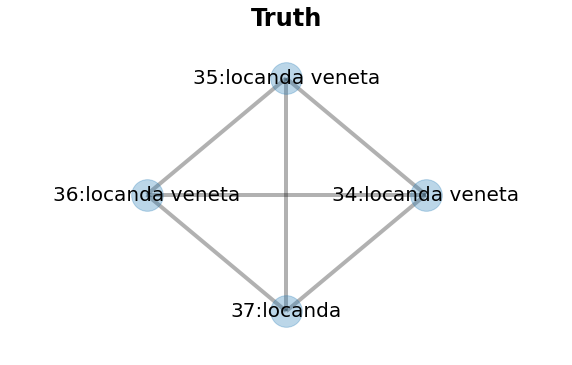

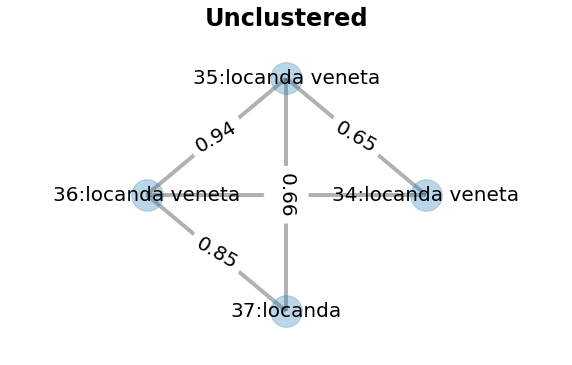

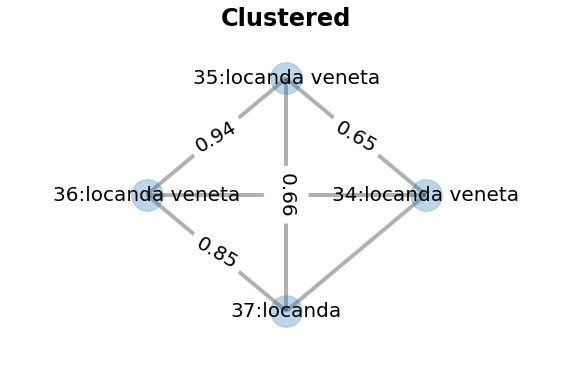

In [58]:
from graph_utils import show_cluster_graphs

score_dict = {tuple(sorted(pair)): score for pair, score in threshold_pairs}
diff_ids = {34, 35, 36, 37}
show_cluster_graphs(
    df,
    golden_pairs_set, cluster_pairs_set, threshold_pairs_set,
    score_dict,
    diff_ids)

,name,addr,city,postal,latlng
800,stefano's,129 fremont st.,las vegas,89101,"(36.1701653, -115.1449582)"
569,golden nugget hotel,129 e. fremont st.,las vegas,89101,"(36.1701653, -115.1449582)"
571,lillie langtry's,129 e. fremont st.,las vegas,89101,"(36.1701653, -115.1449582)"


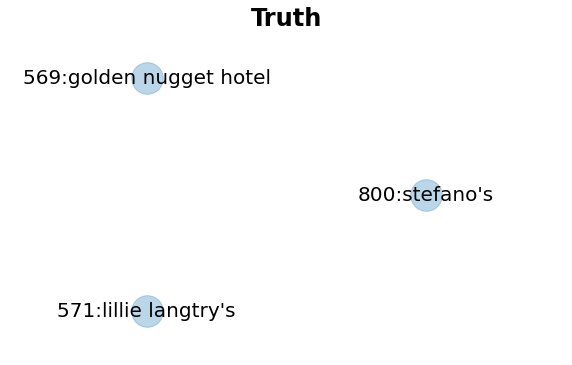

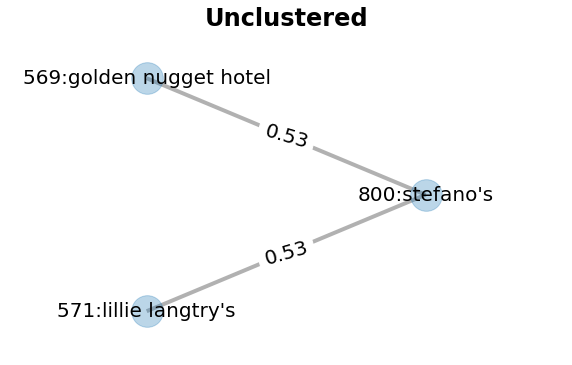

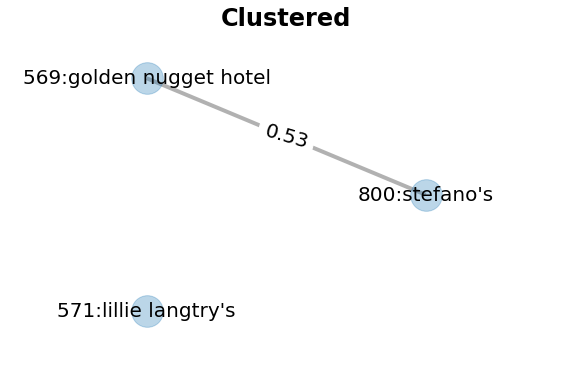

In [59]:
diff_ids = {569, 571, 800}
show_cluster_graphs(
    df,
    golden_pairs_set, cluster_pairs_set, threshold_pairs_set,
    score_dict,
    diff_ids)

## Next Steps

Make sure to learn about other pre-processing methods, indexing techniques, similarity functions, classifiers, etc. Check the talk **The Art and Science of Data Matching** [1] and read the book **Data Matching** [2].

Stay tuned on **[Vinta's blog](https://www.vinta.com.br/blog/)**, I'll be posting additional content on Deduplication there.

Once we have the clusters, how to consolidate data from many records into one? Check for material on **Data Fusion**:
  - [Open issue at Python Record Linkage Toolkit](https://github.com/J535D165/recordlinkage/issues/27)
  - Christen, 6.12 Merging Matches [2]

What if new records arrive? Should we merge, unmerge, move records from clusters? Check for material on **Incremental Record Linkage**:
  - Dedupe approach is to either add to an existing cluster or create a new cluster. You can use a [Gazetteer](https://docs.dedupe.io/en/latest/API-documentation.html#gazetteer-objects) with previously deduped data, then merge new matches into it, and index new nonmatches.
  - Other approaches, check papers:
      * [Online Correlation Clustering](https://arxiv.org/pdf/1001.0920.pdf)
      * [Incremental Record Linkage](http://www.vldb.org/pvldb/vol7/p697-gruenheid.pdf)
      * [Heuristic-based approaches for speeding up incremental record linkage](https://www.sciencedirect.com/science/article/pii/S0164121217302972)

It's worth checking the **Privacy** implications of Record Linkage:
- Christen, chapter 8 [2]
- [k-anonymity](https://desfontain.es/privacy/k-anonymity.html), [k-map](https://desfontain.es/privacy/k-map.html), [δ-presence](https://desfontain.es/privacy/delta-presence.html)
- [Why differential privacy is awesome](https://desfontain.es/privacy/differential-privacy-awesomeness.html)

Check also Rebeca Sarai's talk on **Privacy-preserving methods** at this PyCon US 2020.

Entity Resolution has **ethical implications** that may not be solveable with privacy-preserving algorithms!
- [Law may not be ready yet](https://www.ncrm.ac.uk/news/show.php?article=5444) to protect people's privacy from advanced Entity Resolution and Record Linkage techniques.
- Don't link people that don't want to be linked.
- Don't link records to de-anonymize people.

## References

- **Referenced** by this talk:
    * [1] [Mike Mull, The Art and Science of Data Matching](https://www.youtube.com/watch?v=Y-nYEOgq3YE) (slides [here](https://github.com/mikemull/Notebooks/blob/master/PyDataNYCSlides.ipynb))
    * [2] [Peter Christen, Data Matching](http://www.springer.com/us/book/9783642311635)
    * [3] [Mikhail Yuryevich Bilenko, Learnable Similarity Functions and Their Application to Record Linkage and Clustering](http://www.cs.utexas.edu/~ml/papers/marlin-dissertation-06.pdf)
- Other **talks** about Record Linkage with Python:
    * [Andrew Rowe, Big Data Deduplication and data matching using Python](https://www.youtube.com/watch?v=Z6mlvrYEYnk)
    * [Rhydwyn Mcguire, Record linkage: Join for real life](https://www.youtube.com/watch?v=cEcVIjyHfiQ)
- [Basics of Entity Resolution with Python and Dedupe](https://medium.com/district-data-labs/basics-of-entity-resolution-with-python-and-dedupe-bc87440b64d4)
- [Automating your Data Cleanup with Python](https://blog.kjamistan.com/automating-your-data-cleanup-with-python/)
- [Comparison of Data Matching software](https://github.com/J535D165/data-matching-software)
- [Compilation of Record Linkage resources](https://github.com/ropeladder/record-linkage-resources)

# Thank you!
flavio@vinta.com.br  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
[vinta.com.br](https://www.vinta.com.br?dedupe-slides=1)

Special thanks to Russell Keith-Magee [@freakboy3742](https://twitter.com/freakboy3742), Forest Timothy Gregg [@forestgregg](https://twitter.com/forestgregg), and Jonathan de Bruin [@J535D165](https://github.com/J535D165).